# Analyzing automated loan approval decisions
## Analyzing your decisions time series in Python with Panda dataframes & Seaborn

This Python notebook shows how to load a decision set produced by IBM Digital Business Automation, and how to apply analytics with Seaborn library to get insights on the decisions.
The decision set has been automated by running business rules on randomly generated loan applications. The decision set has been captured by Business Automation Insights and each decision has been written in a JSON format.

This notebook has been developed with a Panda dataframe and runs in Python 3. 

The intent of applying data science on decisions is to check that decision automation works as expected. In other words, we want to check that the executed rules fit well with the segmentation of the data. From there we will potentialy find optimizations to better automate your decision making. You will be able to extend the notebook to create new views on your decisions by using Panda dataframes and Brunel visualization capabilities.
    
To get the most out of this notebook, you should have some familiarity with the Python programming language.

## Contents 
This notebook contains the following main sections:

1. [Load the loan validation decision set.](#overview)
2. [View an approval distribution pie chart.](#viewapprovaldistribution)
3. [View approval density on credit score and amount.](#viewcreditscoreandamountdensity) 
4. [View the loan amount & approval density.](#viewloanamountandapprovaldensity)
5. [View the loan amount on credit score distribution.](#viewamountdistribution)
6. [Summary and next steps.](#next)    

<a id="overview"></a>
## 1. Load the Loan Validation decision set.
The loan validation dataset has been generated with Operational Decision Manager as a JSON file. This file contains 400 decisions serialized in a JSON format.
The following code accesses to this dataset file to construct a dataframe of simple processed loan applications.

In [1]:
import requests

target_url = "https://raw.githubusercontent.com/ODMDev/decisions-on-spark/master/data/loanvalidation/loanvalidation-with-score-grade-bai-timeserie-850.json"

response = requests.get(target_url)
print(response.text[:500],'...')

{"version":"1.0.1","id":"fb081660-eb09-40e3-ab97-fcec8899632c0","timestamp":"2019-07-02T18:43:43.130+02:00","type":"EXECUTION_SUCCESS","odmType":"ruleset","rulesetPath":"/test_deployment/1.0/loan_validation_with_score_and_grade/1.0","offset":5,"partition":1,"duration":5,"data":{"test_deployment.loan_validation_with_score_and_grade.in.loan.numberOfMonthlyPayments":306,"test_deployment.loan_validation_with_score_and_grade.in.loan.startDate":1697068800000,"test_deployment.loan_validation_with_score ...


These functions are used to break the multi JSON file into a list of JSON strings, and make a dictionnary from the list.

In [2]:
#Build a list of JSON string from a string that contains multiple JSON entries
def get_multi_json(json_mono_str):
    json_entries = []
    stack = 0
    json_entry = ''
    
    for letter in json_mono_str:
        json_entry += letter
    
        if letter == '{':
            stack += 1
        if letter == '}':
            stack -= 1
    
        if stack == 0:
            json_entry = json_entry.strip()
            json_entry = json_entry.strip('\n')
            if len(json_entry) > 0:
                json_entries.append(json_entry)
                json_entry = ''
        
        #print('l:', letter)
        #print('entry', json_entry)
        
    return json_entries
    

# Shorten the keys in a second dictionnary
def compact_dictionnary(json_dict):
    
    prefix = "test_deployment.loan_validation_with_score_and_grade."

    dict2 = dict()

    for key,val in json_dict.items():
        start = len(prefix)
        new_key = key[start:].replace(".", "_") 
    
        # Merge key that have a list value to avoid an expansion when buidling a dataframe row
        if new_key == 'out_report_messages':
            #print('key: ', new_key)
            value = decision_data.get(key)
            joined_value = ''
            joined_value = joined_value.join(value)
            dict2[new_key] = joined_value
        else:
            #print('key2: ', new_key)
            dict2[new_key] = decision_data.get(key)
            
    return dict2

# Build a dictionnary from a JSON string
def make_dictionnary(json_str):

    json_dict = json.loads(json_str)
    
    return json_dict

In [3]:
import json

#Segment the monolithic JSON text into a list of JSON texts
json_entries = get_multi_json(response.text)

print(len(json_entries), ' JSON entries parsed')

#for json_entry in json_entries:
 #   print('JSON Entry: ' + json_entry)

#json_entries[0]

850  JSON entries parsed


In [4]:
dict_envelope_entries = []
dict_details_entries = []

#Build a list of Dictionnaries
for json_entry in json_entries:
    #print('JSON Entry: ' + json_entry)
    dict_envelope = make_dictionnary(json_entry)
    dict_envelope_entries.append(dict_envelope)
    
    #Zoom in the data sub dictionnary
    decision_data = dict_envelope['data']
    
    #add the id to allow later on a join between the 2 dictionnaries and subsequent dataframes
    decision_data['id'] = dict_envelope['id']
    #print('id:', decision_data['id'])
    
    dict_details_entries.append(compact_dictionnary(decision_data))

In [5]:
import pandas as pd

rows_envelope_list = []

#Build a dataframe with a row for each top level JSON dictionnary
for dict_entry in dict_envelope_entries:
    rows_envelope_list.append(dict_entry)

df_envelope = pd.DataFrame(rows_envelope_list)
list(df_envelope)

['data',
 'duration',
 'id',
 'odmType',
 'offset',
 'partition',
 'rulesetPath',
 'timestamp',
 'trace.rule.names',
 'trace.task.durations',
 'trace.task.names',
 'type',
 'version']

This dataframe maps in a table the envelope of the decision Business Automation Insights JSON payload. 

In [6]:
df_envelope.iloc[:3]

,data,duration,id,odmType,offset,partition,rulesetPath,timestamp,trace.rule.names,trace.task.durations,trace.task.names,type,version
0,{'test_deployment.loan_validation_with_score_a...,5,fb081660-eb09-40e3-ab97-fcec8899632c0,ruleset,5,1,/test_deployment/1.0/loan_validation_with_scor...,2019-07-02T18:43:43.130+02:00,"[validation.borrower.checkSSNareanumber, valid...","[4, 0, 1, 1, 1]","[loanvalidation, loanvalidation>initResult, lo...",EXECUTION_SUCCESS,1.0.1
1,{'test_deployment.loan_validation_with_score_a...,12,3335b91a-1819-4983-a5ee-f155bc6aa2220,ruleset,6,1,/test_deployment/1.0/loan_validation_with_scor...,2019-07-02T18:43:52.569+02:00,"[validation.borrower.checkSSNareanumber, valid...","[8, 0, 1, 1, 1, 1]","[loanvalidation, loanvalidation>initResult, lo...",EXECUTION_SUCCESS,1.0.1
2,{'test_deployment.loan_validation_with_score_a...,4,9c8ddde9-da2b-427d-9019-0c916f8d28890,ruleset,7,1,/test_deployment/1.0/loan_validation_with_scor...,2019-07-02T18:43:52.604+02:00,"[validation.borrower.checkSSNareanumber, valid...","[4, 0, 1, 2, 1]","[loanvalidation, loanvalidation>initResult, lo...",EXECUTION_SUCCESS,1.0.1


When diving into the data property we access to the details of each decision.

In [7]:
rows_details_list = []

#Build a dataframe with a row for each top level JSON dictionnary
for dict_entry in dict_details_entries:
    rows_details_list.append(dict_entry)

df_details = pd.DataFrame(rows_details_list)
list(df_details)

['',
 'in_borrower_birth',
 'in_borrower_birthDate',
 'in_borrower_creditScore',
 'in_borrower_firstName',
 'in_borrower_lastName',
 'in_borrower_latestBankruptcy',
 'in_borrower_latestBankruptcyChapter',
 'in_borrower_latestBankruptcyDate',
 'in_borrower_latestBankruptcyReason',
 'in_borrower_spouse',
 'in_borrower_ssn_areaNumber',
 'in_borrower_ssn_digits',
 'in_borrower_ssn_fullNumber',
 'in_borrower_ssn_groupCode',
 'in_borrower_ssn_serialNumber',
 'in_borrower_ssncode',
 'in_borrower_yearlyIncome',
 'in_borrower_zipCode',
 'in_loan_amount',
 'in_loan_duration',
 'in_loan_loanToValue',
 'in_loan_numberOfMonthlyPayments',
 'in_loan_startDate',
 'out_grade',
 'out_report_approved',
 'out_report_borrower_birth',
 'out_report_borrower_birthDate',
 'out_report_borrower_creditScore',
 'out_report_borrower_firstName',
 'out_report_borrower_lastName',
 'out_report_borrower_latestBankruptcy',
 'out_report_borrower_latestBankruptcyChapter',
 'out_report_borrower_latestBankruptcyDate',
 'out_

In [8]:
df_details[:3]

,,in_borrower_birth,in_borrower_birthDate,in_borrower_creditScore,in_borrower_firstName,in_borrower_lastName,in_borrower_latestBankruptcy,in_borrower_latestBankruptcyChapter,in_borrower_latestBankruptcyDate,in_borrower_latestBankruptcyReason,...,out_report_loan_loanToValue,out_report_loan_numberOfMonthlyPayments,out_report_loan_startDate,out_report_message,out_report_messages,out_report_monthlyRepayment,out_report_validData,out_report_yearlyInterestRate,out_report_yearlyRepayment,out_score
0,fb081660-eb09-40e3-ab97-fcec8899632c0,-2308867200000,-2308867200000,590,John,Smith,None,-1,None,None,...,0.5,306,1697068800000,Average risk loan\nToo big Debt/Income ratio: ...,Average risk loanToo big Debt/Income ratio: 1....,3791.428956,True,0.081,45497.147473,730.0
1,3335b91a-1819-4983-a5ee-f155bc6aa2220,862099200000,862099200000,520,John,Smith,None,-1,None,None,...,0.5,269,1776297600000,Very low risk loan\nCongratulations! Your loan...,Very low risk loanCongratulations! Your loan h...,572.980467,True,0.068,6875.765598,690.0
2,9c8ddde9-da2b-427d-9019-0c916f8d28890,250560000000,250560000000,510,Betty,Smith,None,-1,None,None,...,0.6,198,1655510400000,Low risk loan\nToo big Debt/Income ratio: 0.98...,Low risk loanToo big Debt/Income ratio: 0.98We...,2211.376379,True,0.064,26536.516543,610.0


A dataframe has been created to capture the 850 loan application decisions automated with business rules. Business rules have been used to determine eligibility based credit score, loan amount, income to debt ratio. Decision outcomes are represented by the approval and yearlyReplayment columns.

In [9]:
total_rows = df_details.shape[0]
print("The size of the detailed decision set is " + str(total_rows))

The size of the detailed decision set is 850


<a id="viewapprovaldistribution"></a>
## 2.View the loan approval distribution in a donut chart.
A simple donut chart that shows the approval distribution in the decision set.

<IPython.core.display.Javascript object>


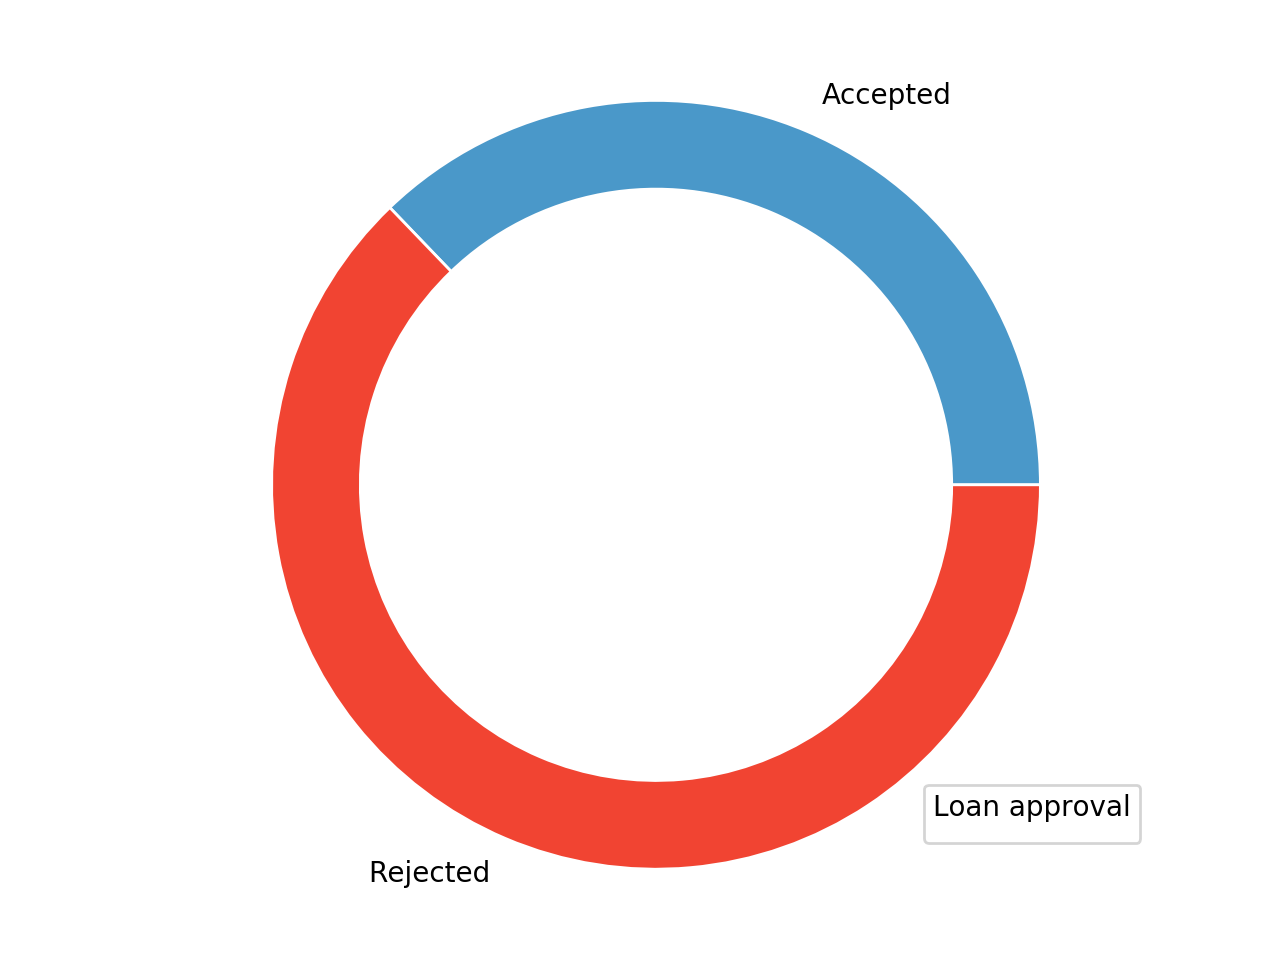

In [13]:
import numpy as np
import seaborn as sns

%matplotlib notebook

# Libraries
import matplotlib.pyplot as plt
 
total_accepted = df_details['out_report_approved'].sum()
total_rejected = df_details['out_report_approved'].count() - total_accepted

# Make data: I have 2 groups
group_names=['Accepted', 'Rejected']
group_size=[total_accepted,total_rejected]

#subgroup_names=['Accepted.1', 'Accepted.2', 'Rejected.1', 'Rejected.2']
#subgroup_size=[2,6,1,1]
 
# Create colors
a, b=[plt.cm.Blues, plt.cm.Reds]
 
# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.6), b(0.6)] )
plt.setp( mypie, width=0.3, edgecolor='white')
 
legend = plt.legend(handles=[], title="Loan approval", loc=4, fontsize='small', fancybox=True)
    
# show it
plt.show()

<a id="viewcreditscoreandamountdensity"></a>
## 3.View the loan approval decisions on the credit score and loan amount bivariate distribution.


We visualize the decision set in a credit score and loan amount bi-dimentional space. Each decision colored depending on the approval outcome.
We can distinguish for this dataset that all applications with a credit score under 200 have been rejected. Similarly the applications with a loan amount greater than 600K have been rejected too. In the remaining area accepted and rejected applications coexist without showing a frontier. The most probable cause is that the decision making is performed on other features describing the borrrower and the loan.

<IPython.core.display.Javascript object>


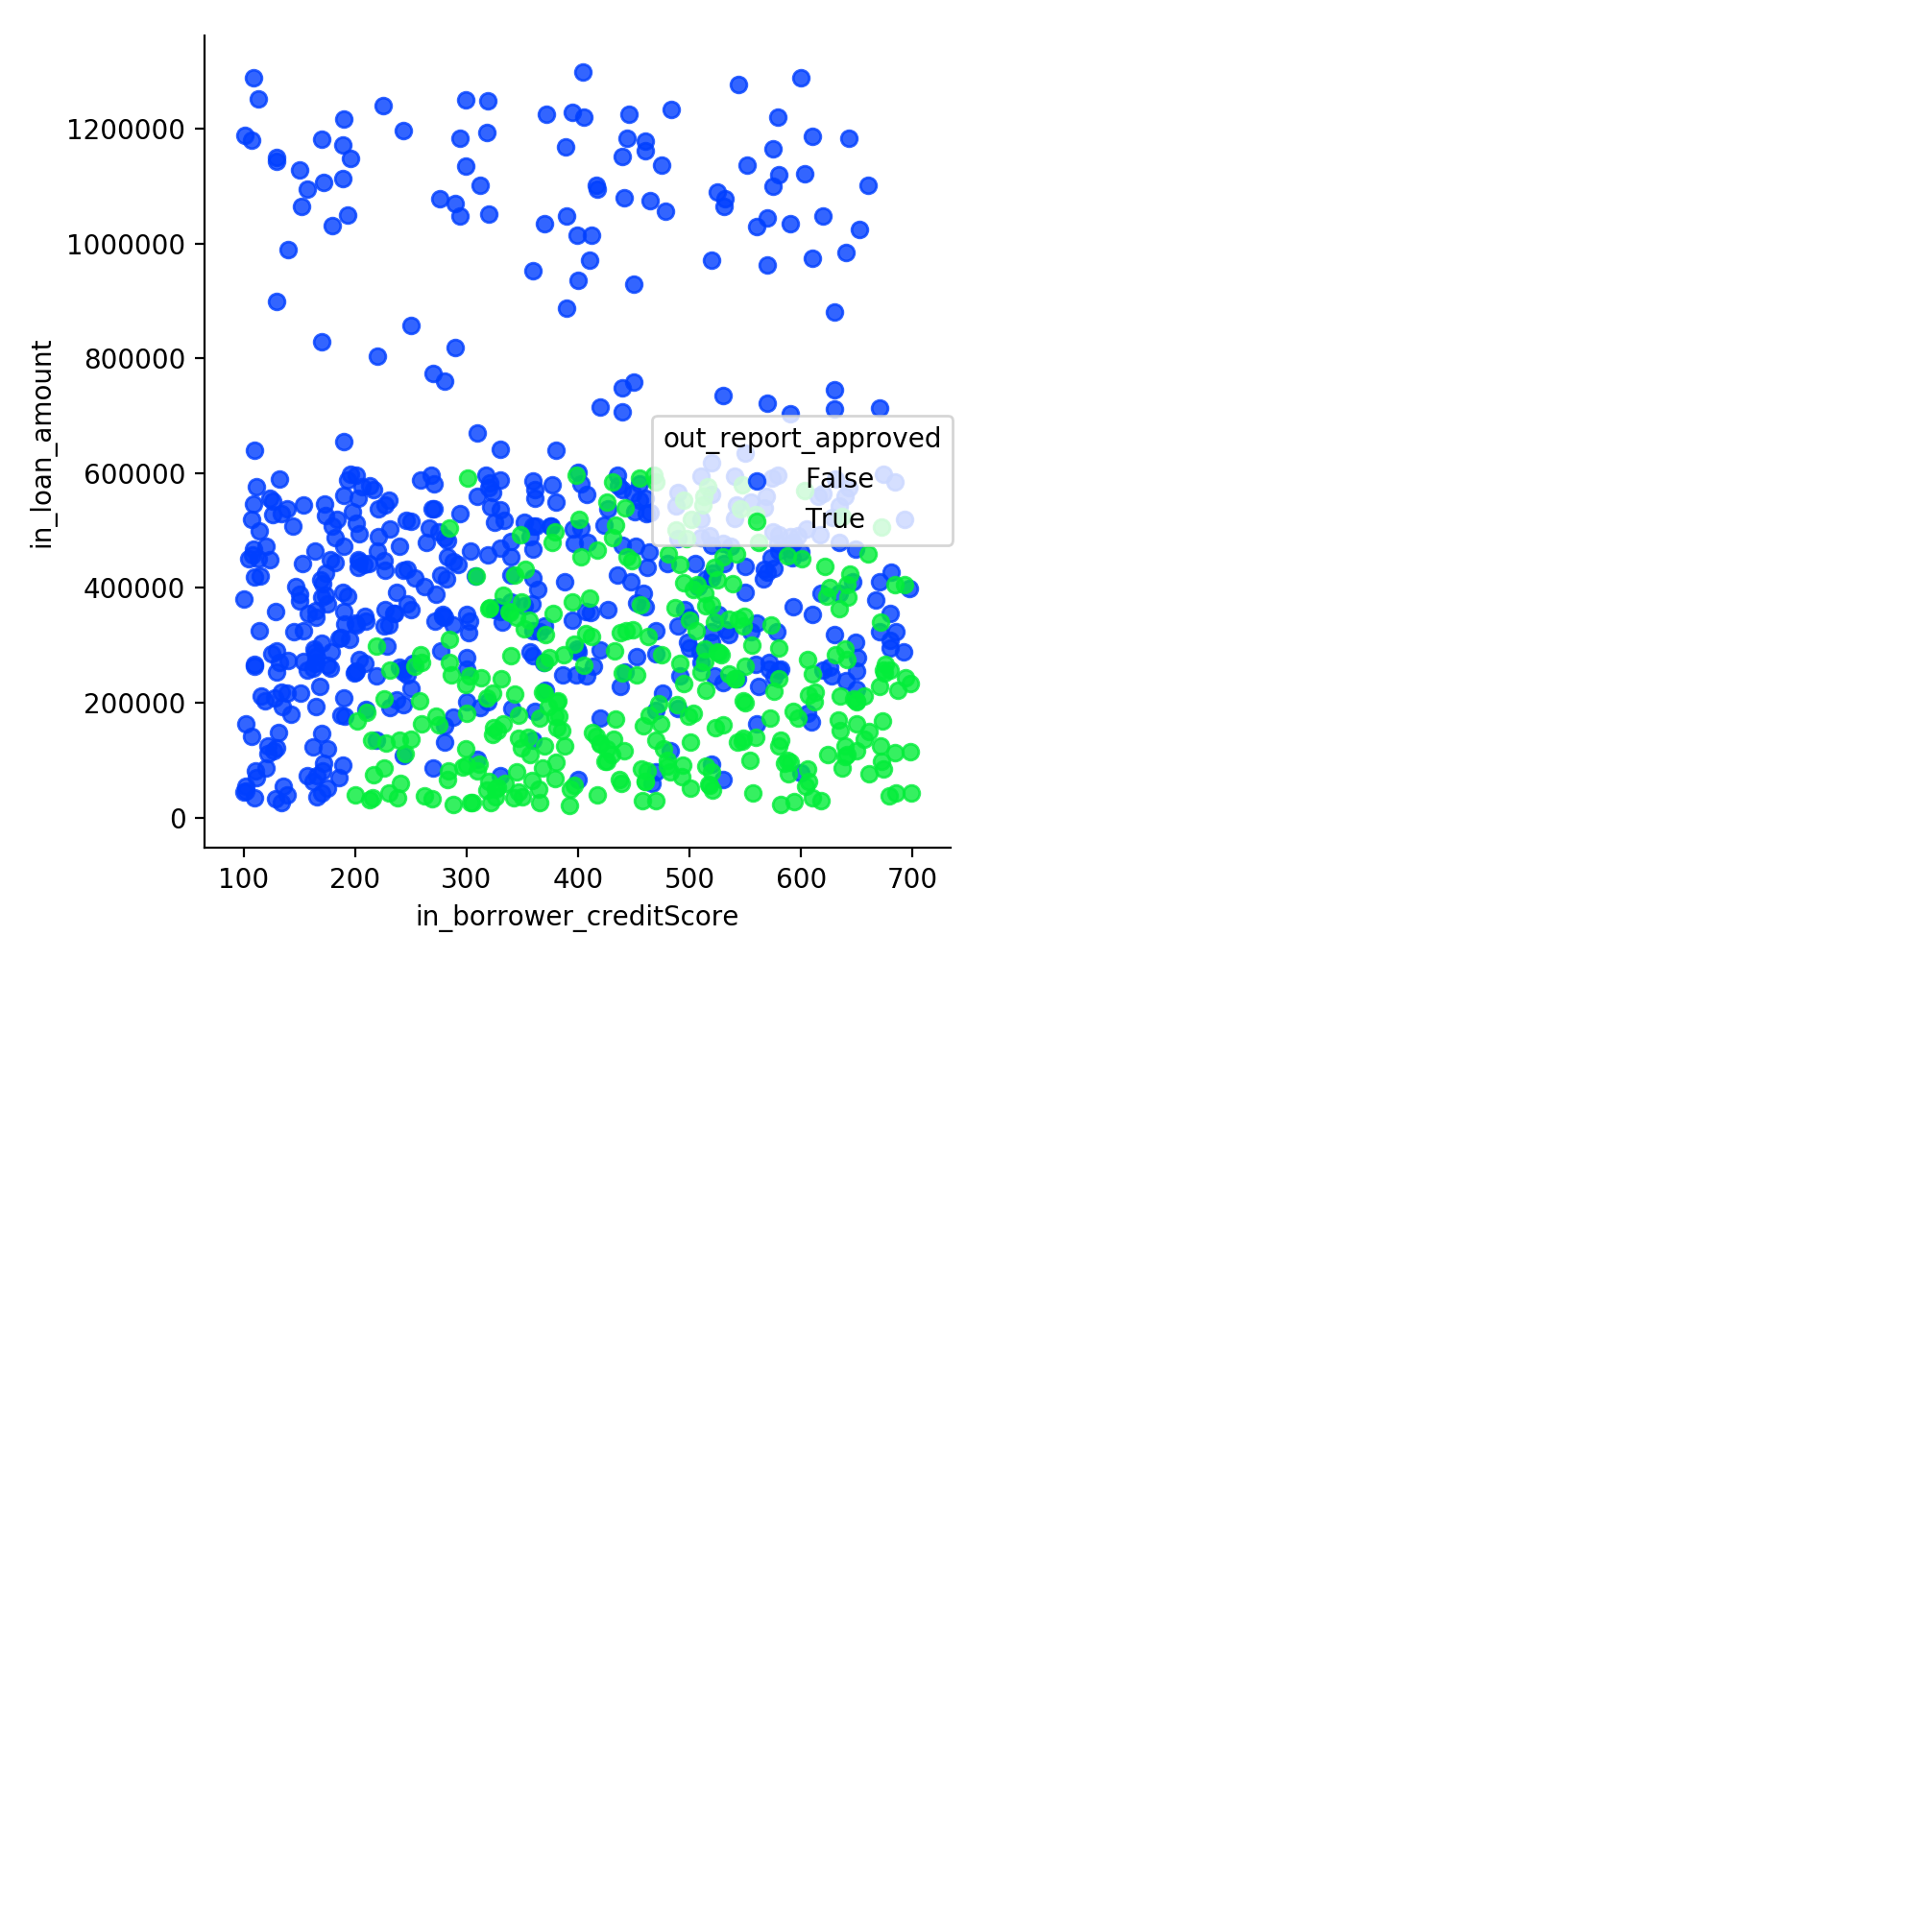

In [18]:
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="in_borrower_creditScore", y="in_loan_amount", data=df_details, fit_reg=False, hue='out_report_approved', legend=True, palette="bright")

The 200 credit score frontier to accept a loan in the decision set looks confirmed by visualing the density of decisions based on the credit score and outcome.

<IPython.core.display.Javascript object>


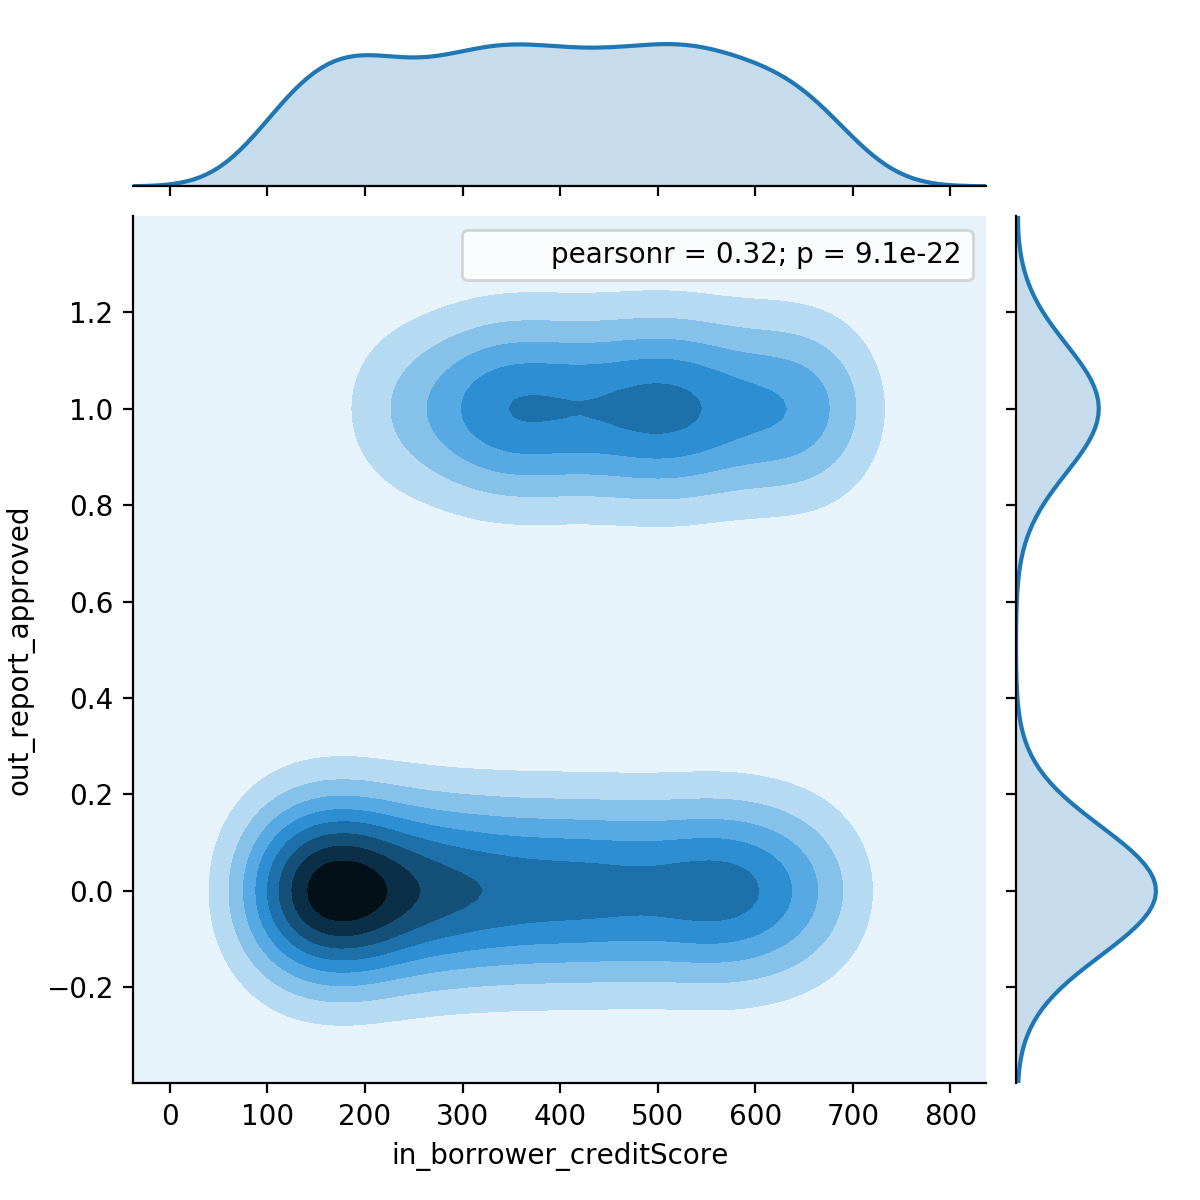

In [19]:
sns.jointplot(x="in_borrower_creditScore", y="out_report_approved", data=df_details, kind="kde");

<a id="viewloanamountandapprovaldensity"></a>
## 4.View approvals at the light of the borrower incomes.
Do we see trends or limits in income for accepted loan applications? We can observe graphically that the larger is the yearly income value the more accepted approval we get.

<IPython.core.display.Javascript object>


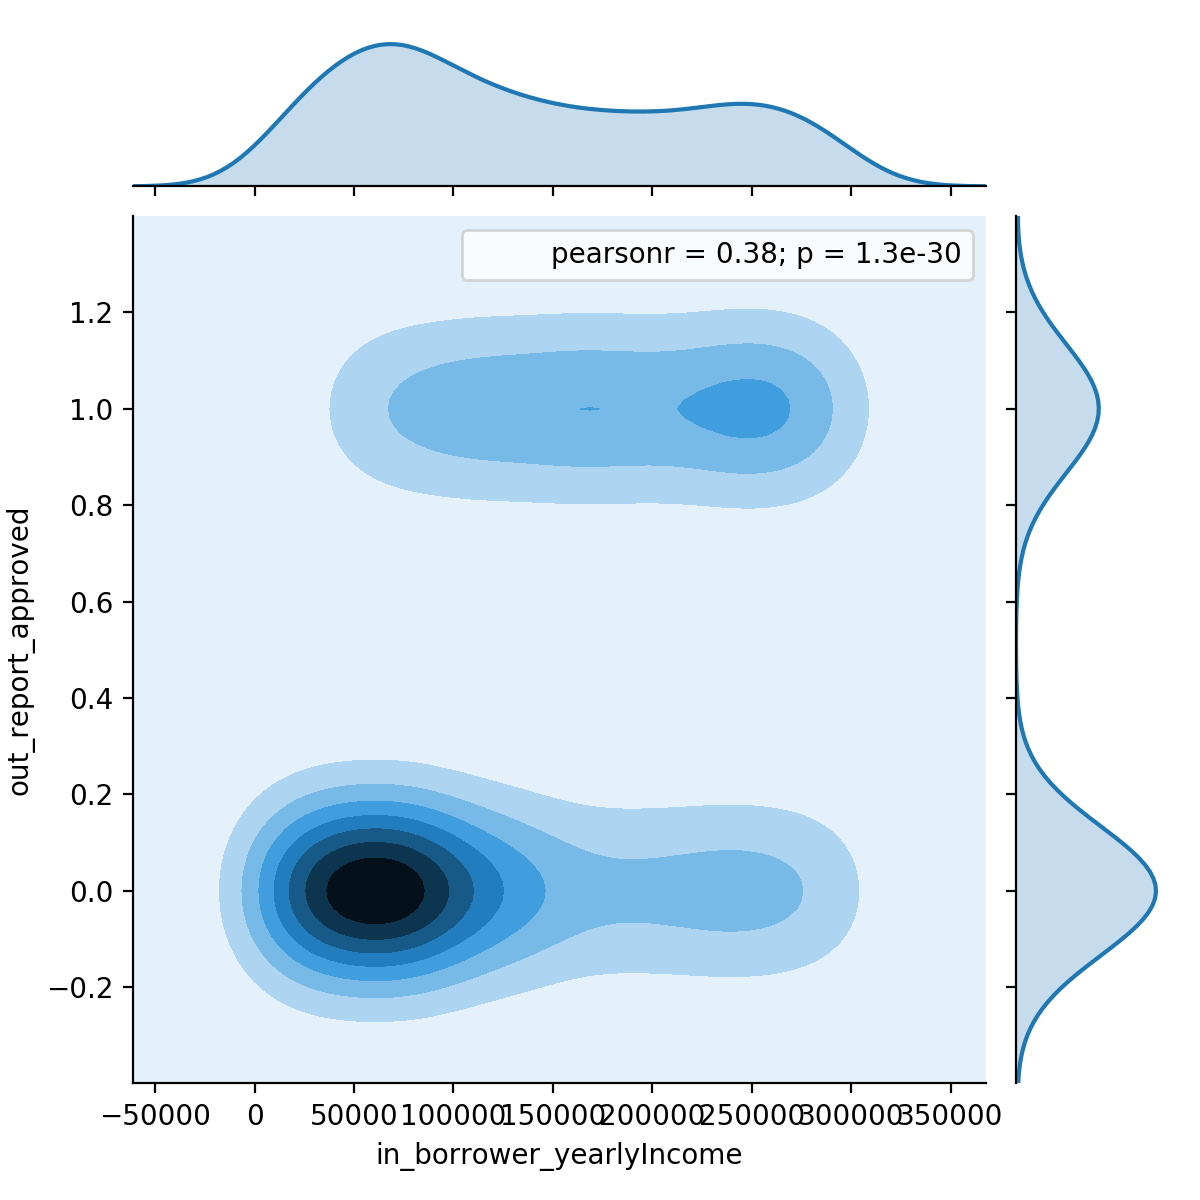

In [16]:
sns.jointplot(x="in_borrower_yearlyIncome", y="out_report_approved", data=df_details, kind="kde");

<a id="viewamountdistribution"></a>
## 5.Loan amount distribution.
We use here a scatterplot to visualize the distribution of the applications on the credit score and amount.
The credit score distribution looks very balanced in the sunthetic dataset. Amounts are highy concentrated under 600 K.

<IPython.core.display.Javascript object>


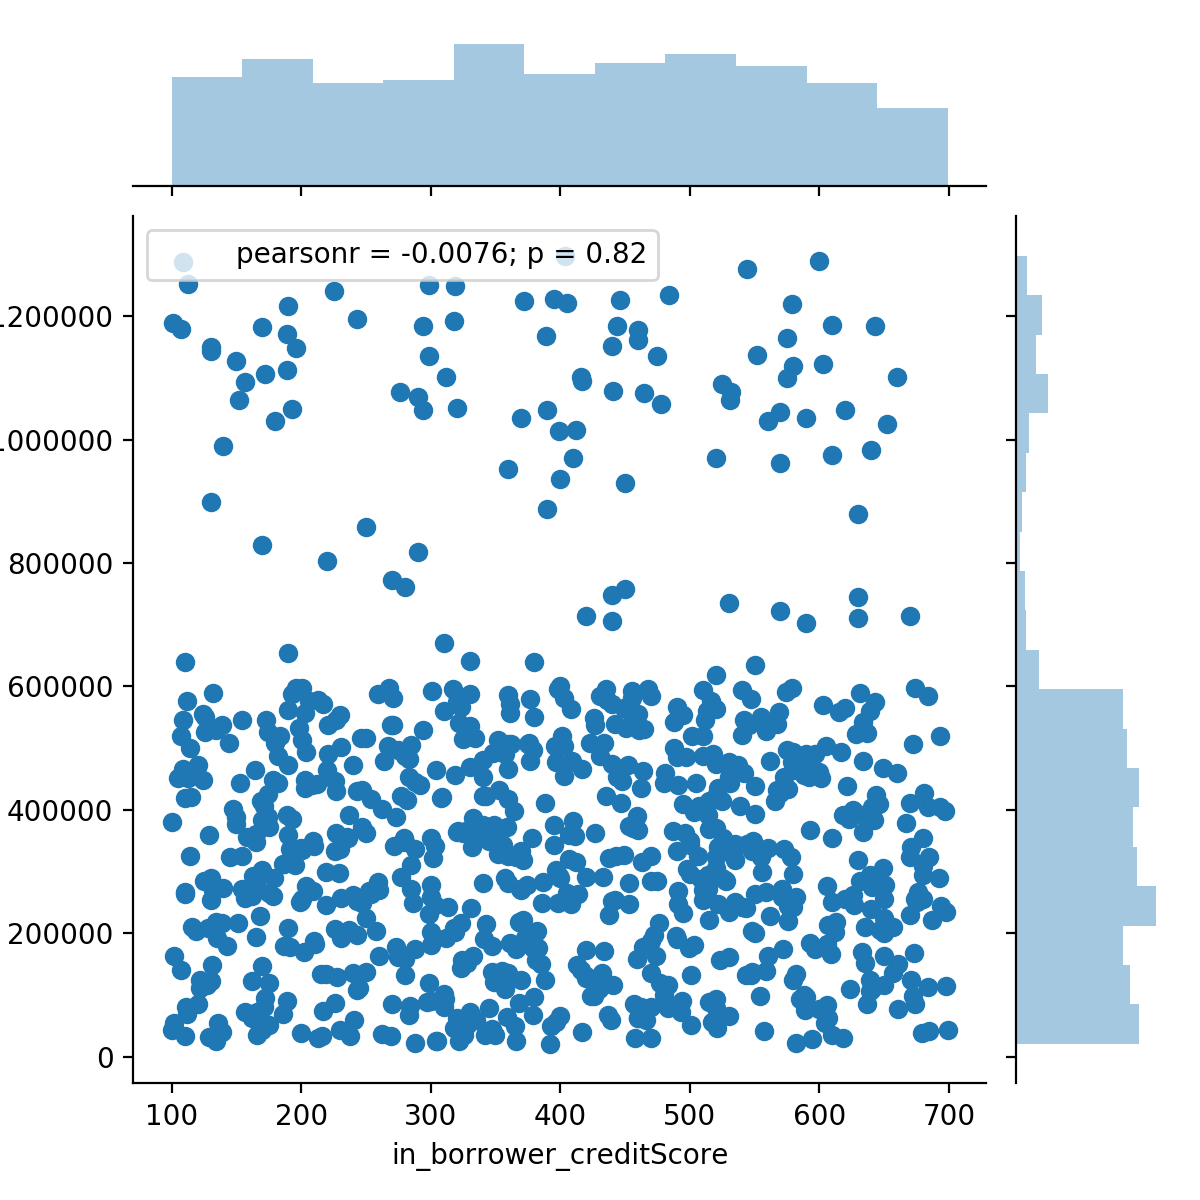

In [21]:
from scipy import stats

sns.jointplot(x="in_borrower_creditScore", y="in_loan_amount" , data=df_details);

<a id="next"></a>
# Summary and next steps
You have manipulated dataframes and views of a decision set powered by IBM DBA and captured in a BAI JSONL format. You can expand this notebook by adapting the views and adding new ones to get more insights about your decisions and make better decisions in the future.

Copyright © 2019 IBM. This notebook and its source code are released under the terms of the MIT License.

<a id="authors"></a>
## Authors

Marie-Francoise Lim Meffre and Pierre Feillet are engineers at the IBM Decision Lab. Marie-Francoise is senior developer taking care of the decision automation samples.
Pierre is architect in decision automation, and is passionate about data science and machine learning.

Copyright © 2019 IBM. This notebook and its source code are released under the terms of the MIT License.